**PBS ADSORPTION STUDIES**

Rodrigo Toledo de Araujo \\
 Department of Electrical Engineering and Computation \\
 University of Campina Grande \\
 Campina Grande, Paraíba, Brazil

 rodrigo.araujo@ee.ufcg.edu.br

# **0. Molecular Analysis and Dilution**

Molarity ($M$) is defined as the number of moles of solute ($n$) per liter of solution ($V$).

\begin{equation}
M = \frac{n}{V}
\end{equation}

The relationship between moles ($n$), mass ($m$), and molar mass ($M_m$), is shown in \autoref{eq:moles}.

\begin{equation}
n = \frac{m}{M_m}
\end{equation}

\autoref{eq: mass} is typically used to find the required mass ($m$) for the proposed molarity (Combining \autoref{eq:molarity} and \autoref{eq:moles}).

\begin{equation}
m = M \times V \times M_m
\end{equation}

As in the NaOH experiment, the different concentrations of NaOH were produced by making a dilution of one bigger concentration (See \autoref{eq:dilution} for more details).

\begin{equation}
    C_{\text{new}}V_{\text{new}} = C_{\text{initial}}V_{\text{initial}}
\end{equation}

# 1. Importing Libraries

In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import pandas as pd
from scipy.optimize import minimize
from cycler import cycler
import re
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
from typing import Callable, List
import subprocess
from scipy.integrate import solve_ivp


In [6]:
# # Testing the backend
# # Comando para obter informações sobre a GPU usando nvidia-smi
# command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# # Execute o comando e capture a saída
# output = subprocess.check_output(command, shell=True, encoding="utf-8")
# # Separe as linhas da saída
# lines = output.strip().split("\n")
# # imprima as informações da saída
# for idx, line in enumerate(lines):
#     name, memory = line.strip().split(",")
#     print(f"GPU {idx} - Nome: {name}, Memória Total: {memory} MB")
#     print(f"Jax backend:{jax.default_backend()}")
# jax.devices()

GPU 0 - Nome: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Memória Total:  6144 MB
Jax backend:gpu


[CudaDevice(id=0)]

In [2]:
# Use LaTeX for text rendering
# Define a more scientific color cycle
scientific_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.labelsize": 12,
        "font.size": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.prop_cycle": cycler(color=scientific_colors),
    }
)

# 1. Fitting the NaOH data into the Langmuir Model

## 1.1 Theory

In 1932, Langmuir developed the Langmuir adsorption isotherm, which describes the adsorption and desorption of molecules on a surface \cite{langmuir1932vapor}.

Following the principles of physical chemistry for reaction kinetics and thermodynamics the change in the amount of solute adsorbed on a surface per unit area over time can be expressed in the following equation \cite{latour2015langmuir}.



$$\frac{dq}{dt} = k_aC(Q-q)-k_dq$$


where $C$ is the solution concentration, $Q$ is the amount of solute adsorbed when all of the biding sites are filled, $q$ is the amount of solute adsorbed on the surface given a solution concentration $C$, $t$ is the time and $(Q-q)$ is the number of vacant sites for adsorption.

Under dynamic equilibrium conditions, $dq/dt=0$, the equilibrium constant and $q$ are given by:

$$K_A=\frac{k_a}{k_d} = \frac{q}{C(Q-q)}$$

$$q =\frac{QC}{C+K_A^{-1}}$$

The following equation is used  to quantify adsorption coverage (i.e. normalized coverage $0<\Theta<1$).

$$\Theta = \frac{\text{Occupied region}}{\text{Total available region}} = \frac{q}{Q}=\frac{V_a}{V_m} = \frac{m_a}{m_m}$$

where $\Theta $ represents the coverage of the surface, $ V_a $ is the volume of the adsorbate adhered, $ V_m $ is the maximum volume of adsorbate in a monolayer, $ m_a $ is the number of moles adhered, and $ m_m $ is the maximum number of moles of adsorbate in a monolayer.

Then, the first order differential equation (i.e. Langmuir isotherm) in terms of the normalized coverage is:

$$\frac{d(q/Q)}{dt}=\frac{d\Theta}{dt} = k_aC(1-\Theta)-k_d\Theta$$

And has exponential solutions (i.e. $\Theta(t)$) given by:

   $$ \Theta(t) = \left(\frac{k_aC}{k_aC+k_d}\right)\left(1-e^{-({k_aC+k_d})t}\right), \quad \text{or}\quad
\Theta(t) = \left(\frac{C}{C+K_A^{-1}}\right)\left(1-e^{-({k_aC+k_d})t}\right)$$

The molecular surface under steady state conditions, from the previous equation is given by:

$$\Theta^\infty=\lim_{t\rightarrow\infty}\Theta(t)=\frac{C}{C+K_A^{-1}}$$




## 1.2 Applying the model to the PBS (Find the kinetic constants)

### A. Theory

The effective refractive index variation $\Delta \mathcal{N}_s^{\text{eff}}$ can be estimated by using the surface coverage (i.e., $\Theta_{\text{mol}}(C_s)$, derived from one of the adsorption models) as shown in the following equation:

$$\Delta \mathcal{N}_s^{\text{eff}}(C_s) = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\Theta_{\text{mol}}(C_s)$$

Being:

$$\Theta_{\text{mol}}(C)=\frac{C}{C+K_A^{-1}}\theta_\infty$$

Then:

$$\Delta \mathcal{N}_s^{\text{eff}} = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\frac{C}{C+K_A^{-1}}\theta_{\infty} \longrightarrow\Delta \mathcal{N}_s^{\text{eff}}K_A^{-1}-\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty} C=-C\Delta \mathcal{N}_s^{\text{eff}}$$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

Where:

* $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$, $\theta_{\infty}$  and $K_A^{-1}$ are the constant unknowns
* $C$ and $\Delta \mathcal{N}_s^{\text{eff}}$ are the coefficients (we already know their values) that vary.

Given that the values of the two points [($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$)] are known, by using a numerical method (e.g., Gauss method), the unknown variables are quickly defined.

### B. Importing data and visualization

In [4]:
# Step 2: Define the directory containing the Excel files
#dir_path = "/home/toledorodrigo/Data_NaOH/data_excel"
dir_path = "G:\My Drive\Colab Notebooks\Biosensors\Data\Data_NaOH\data_excel"
# Step 3: Initialize an empty dictionary to store data
data_dict = {}

# Step 4: List all files in the directory
file_list = os.listdir(dir_path)

file_list = sorted(file_list)

# Step 6: Loop through the sorted files and read each Excel file into the dictionary
for file_name in file_list:
    if file_name.endswith(".xlsx"):
        file_path = os.path.join(dir_path, file_name)
        data_dict[file_name] = pd.read_excel(file_path)

<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rodri\AppData\Local\Temp\ipykernel_11424\3739119326.py:3: SyntaxWarning: invalid escape sequence '\M'
  dir_path = "G:\My Drive\Colab Notebooks\Biosensors\Data\Data_NaOH\data_excel"


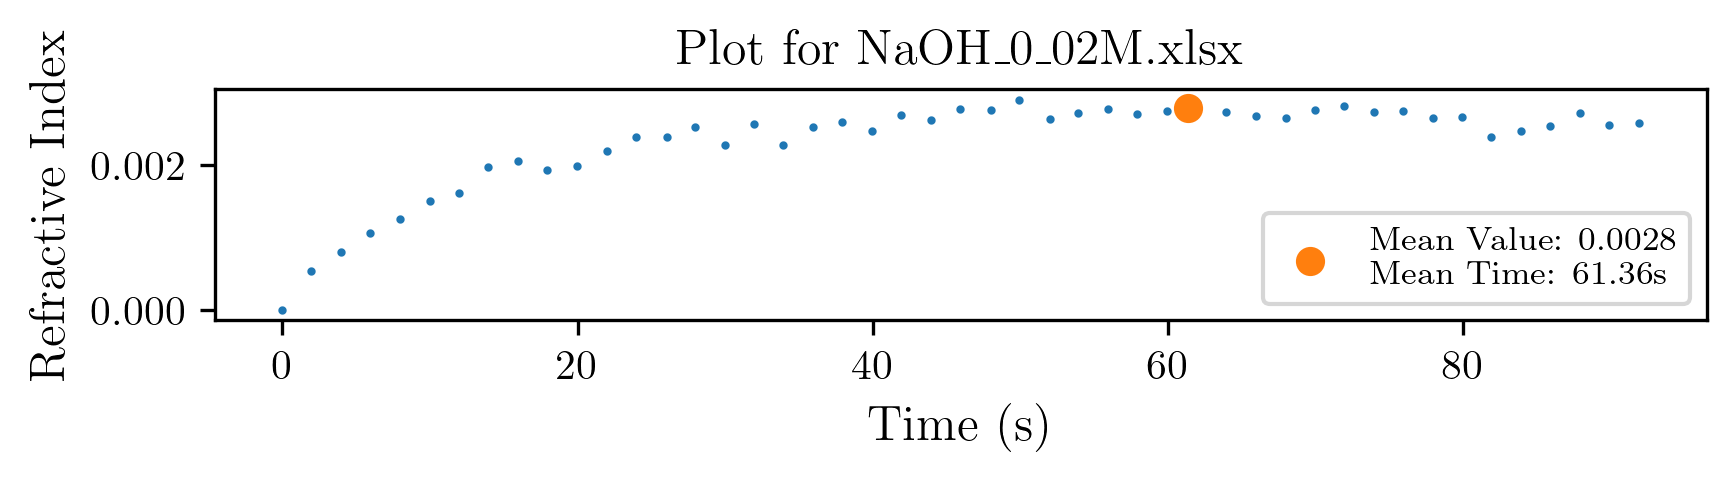

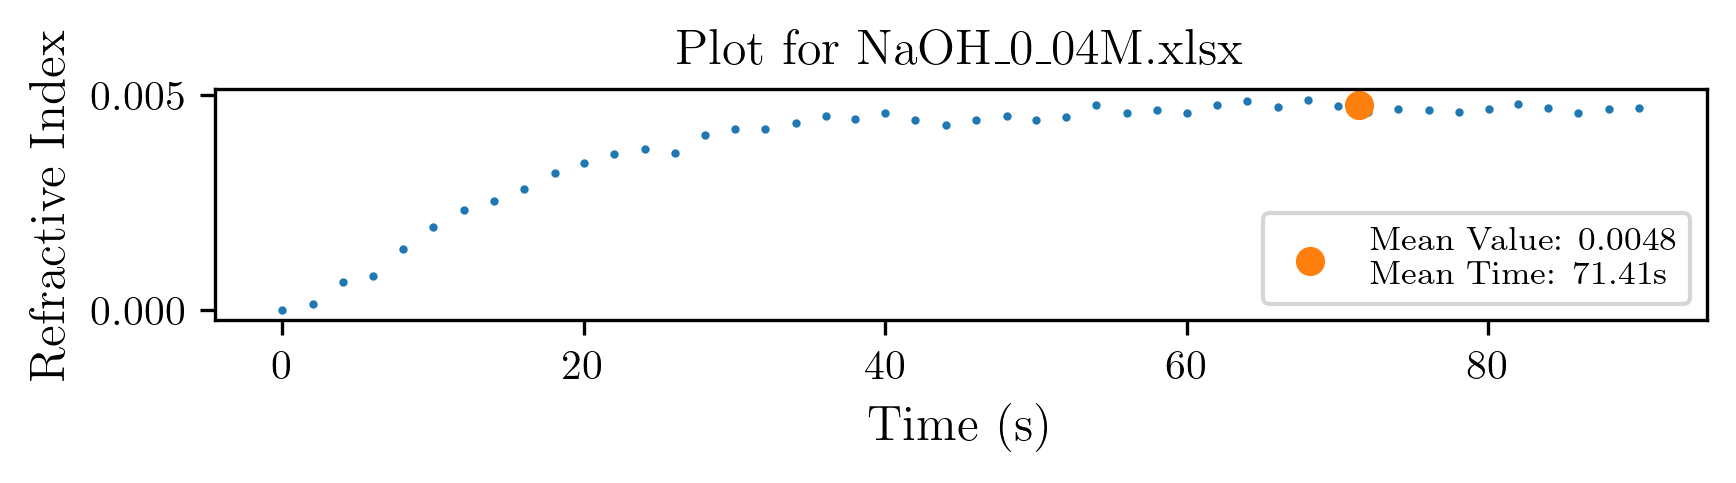

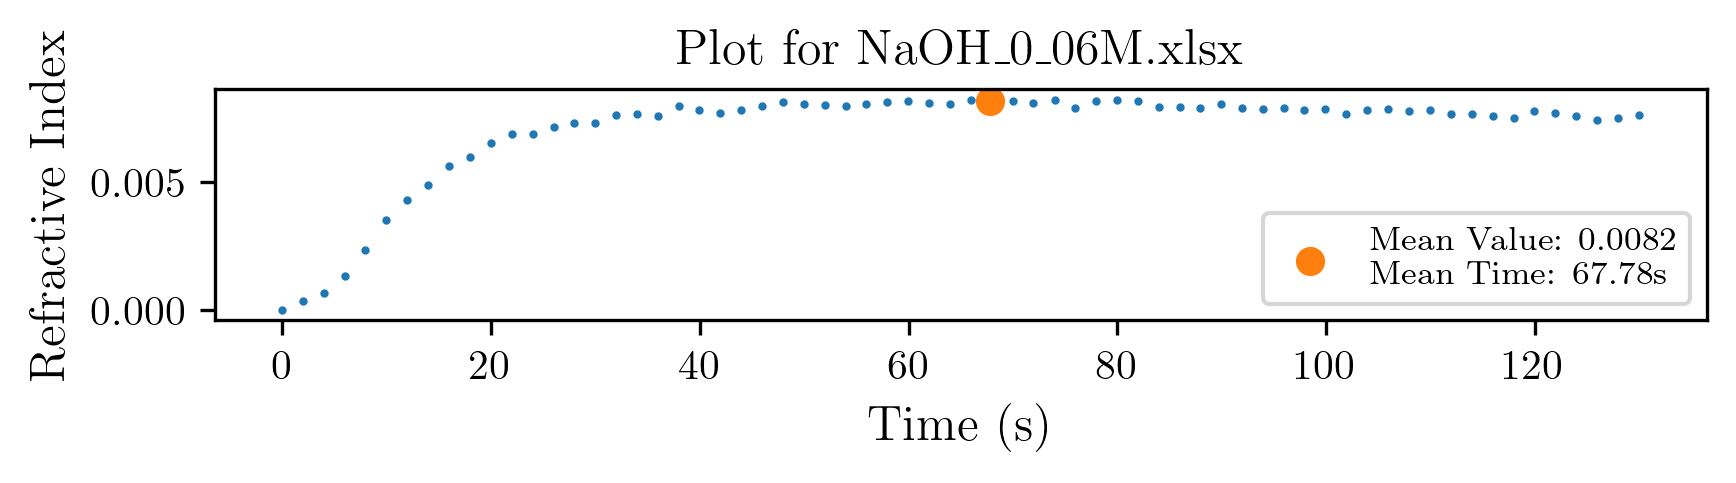

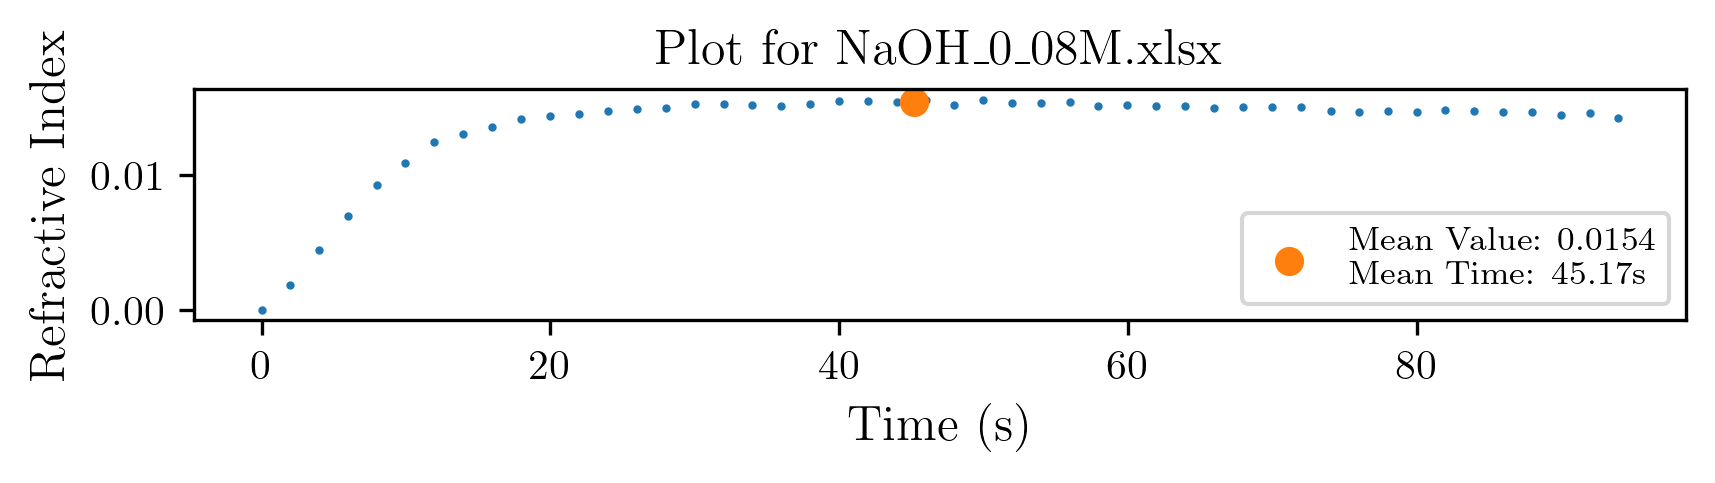

In [5]:
max_values_dict = {}
concentration = [0.02, 0.04, 0.06, 0.08]
window_size = 10  # Set this to the number of top values you want to average
time_array = []
refrac_index_array = []

for i, (file_name, data) in enumerate(data_dict.items()):
    # Getting the time and the refractive index
    time = data["Time"] / 1e3
    refrac_var = data[" Refractive Index"] / 1e3
    refrac_index_array.append(refrac_var)
    time_array.append(time)
    # Sort the refractive index and get the indices of the top 'window_size' values
    top_indices = refrac_var.nlargest(window_size).index

    # Get the mean of the top 'window_size' refractive index values and corresponding times
    mean_value = refrac_var.loc[top_indices].mean()
    mean_time = time.loc[top_indices].mean()

    # Store the mean values in the dictionary
    max_values_dict[file_name] = {
        "mean_value": mean_value,
        "mean_time": mean_time,
        "concentration": concentration[i],  # Add the corresponding concentration
    }

    # Plotting the time versus refractive index
    fig, ax = plt.subplots(figsize=(6.417, 1), dpi=300)
    ax.scatter(time, refrac_var, s=1)
    ax.scatter(
        mean_time,
        mean_value,
        label=f"Mean Value: {mean_value:.4f}\nMean Time: {mean_time:.2f}s",
    )
    ax.set_ylabel("Refractive Index")
    ax.set_xlabel("Time (s)")
    ax.legend(fontsize=8)

    # Add a title with the file name for reference
    ax.set_title(f"Plot for {file_name}")

    # Show the plot
    plt.show()


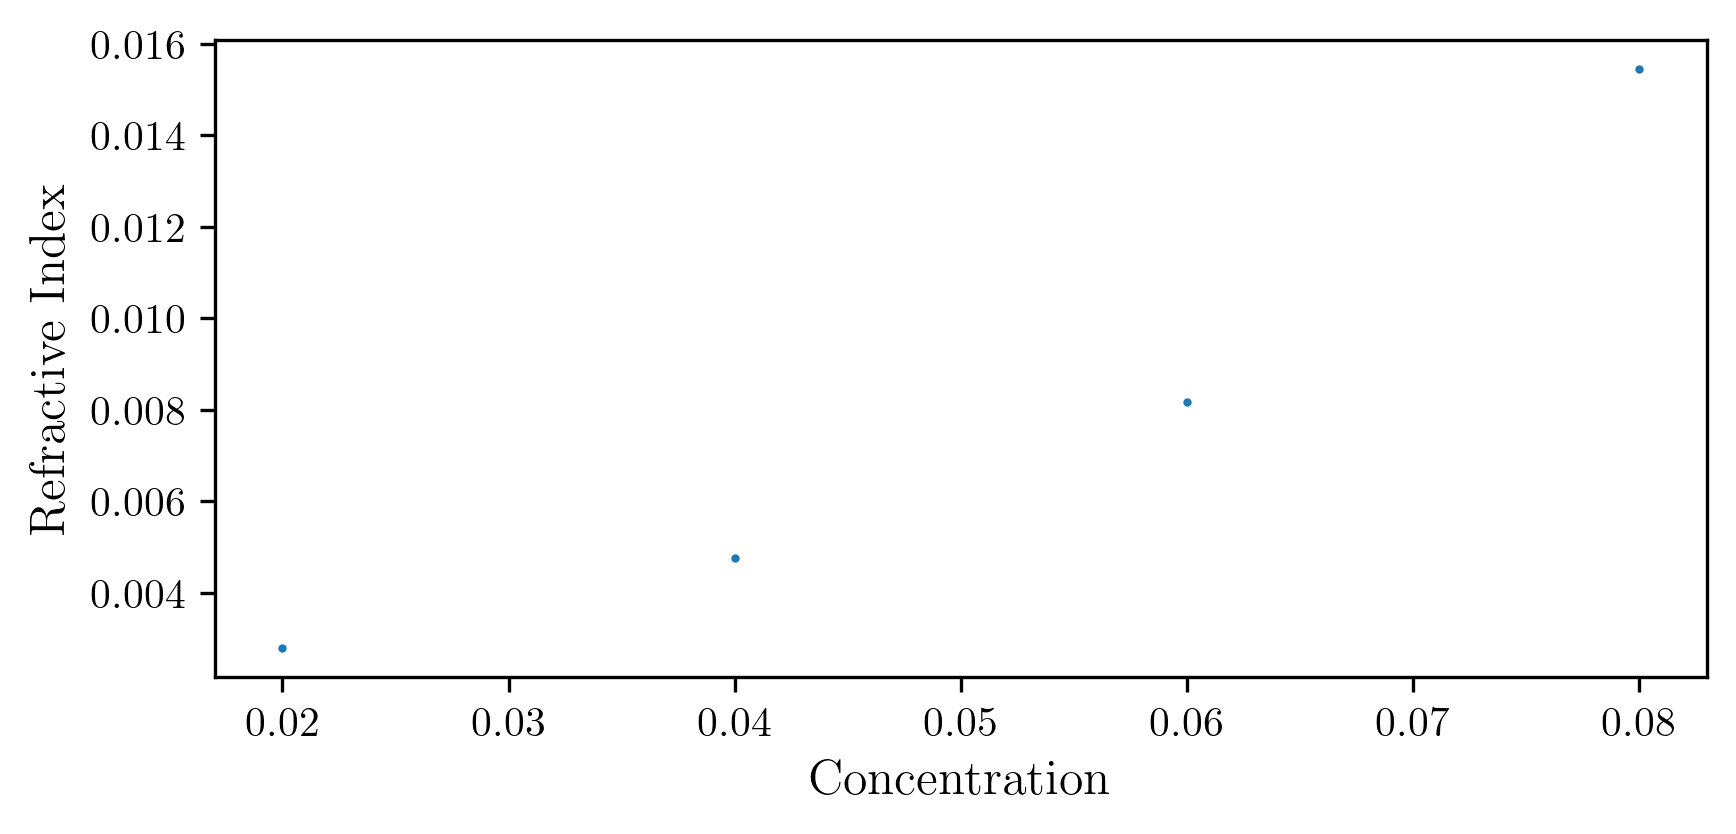

In [6]:
# Plotting the maximum value over the concentration
fig, ax = plt.subplots(figsize=(6.417, 2.7559), dpi=300)
ax.set_ylabel("Refractive Index")
ax.set_xlabel("Concentration")
max_values = []
for file_name, data in max_values_dict.items():
    max_values.append(data["mean_value"])
    ax.scatter(data["concentration"], data["mean_value"], s=1, color="#1f77b4")

C1 = max_values_dict["NaOH_0_02M.xlsx"]["concentration"]
C2 = max_values_dict["NaOH_0_08M.xlsx"]["concentration"]
R1 = max_values_dict["NaOH_0_02M.xlsx"]["mean_value"]
R2 = max_values_dict["NaOH_0_08M.xlsx"]["mean_value"]

In [11]:
# # Saving the figure
# fig.savefig('/content/drive/MyDrive/UFCG/Mestrado/Biosensors/MILKGOATADULTERATION/Plots/Cow_Goat_100_70_30_20_10_05_01.png', bbox_inches='tight')
# files.download('/content/drive/MyDrive/UFCG/Mestrado/Biosensors/MILKGOATADULTERATION/Plots/Cow_Goat_100_70_30_20_10_05_01.png')

### C. Finding $K_a$ and $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

In [7]:
C1 = max_values_dict["NaOH_0_02M.xlsx"]["concentration"]
C2 = max_values_dict["NaOH_0_06M.xlsx"]["concentration"]
R1 = max_values_dict["NaOH_0_02M.xlsx"]["mean_value"]
R2 = max_values_dict["NaOH_0_06M.xlsx"]["mean_value"]
A = np.array([[R1, -C1], [R2, -C2]])
B = np.array([-C1 * R1, -C2 * R2])
S = np.linalg.solve(A, B)
Ka = S[0] ** (-1)
var_n_mol_thetainf = S[1]

In [8]:
Constants_1 = {
    "Ns1": [R1],
    "C1": [C1],
    "Ns2": [R2],
    "C2": [C2],
    "KA": [Ka],
    "Nmol": [var_n_mol_thetainf],
}

df_Constants_1 = pd.DataFrame(Constants_1)
df_Constants_1

,Ns1,C1,Ns2,C2,KA,Nmol
0,0.002786,0.02,0.008159,0.06,0.614995,0.229259


### D. Finding $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$ and $\theta_{\infty}$

In [9]:
def fit_thermodynamic_parameters(N_eff_exp, Ka, C_exp, initial_guess):
    def model(params):
        N_mol_max, Theta_inft = params
        N_eff = N_mol_max * Theta_inft * C_exp / (C_exp + (1 / Ka))
        return N_eff

    def objective_function(params):
        N_eff_model = model(params)
        MSE = np.mean((N_eff_model - N_eff_exp) ** 2)
        return MSE

    # Define the constraint N_mol_max*Theta_inft = 0.402483
    def constraint(params):
        N_mol_max, Theta_inft = params
        return N_mol_max * Theta_inft - var_n_mol_thetainf

    # Initial guess
    N_mol_max_initial, Theta_inft_initial = initial_guess

    # Constraints dictionary for scipy.optimize.minimize
    constraints = {"type": "eq", "fun": constraint}

    # Perform the optimization
    result = minimize(
        objective_function,
        [N_mol_max_initial, Theta_inft_initial],
        method="SLSQP",
        constraints=constraints,
    )

    # Extract the optimized parameters
    N_mol_max_opt, Theta_inft_opt = result.x
    mse = result.fun

    return N_mol_max_opt, Theta_inft_opt, mse

In [10]:
# Initial guesses for ka and kd
C_values = np.array(concentration)
initial_guess = [0.01, 1]
N_mol_max_opt, Theta_inft_opt, mse = fit_thermodynamic_parameters(
    max_values, Ka, C_values, initial_guess
)

In [11]:
fitvalues = {
    "MSE": [mse],
    "N_mol_max_opt": [N_mol_max_opt],
    "Theta_inft_opt": [Theta_inft_opt],
}
pd.DataFrame(fitvalues)

,MSE,N_mol_max_opt,Theta_inft_opt
0,0.000006,0.228778,1.002103


#### 1.3.1.2 Making the isotherm plot

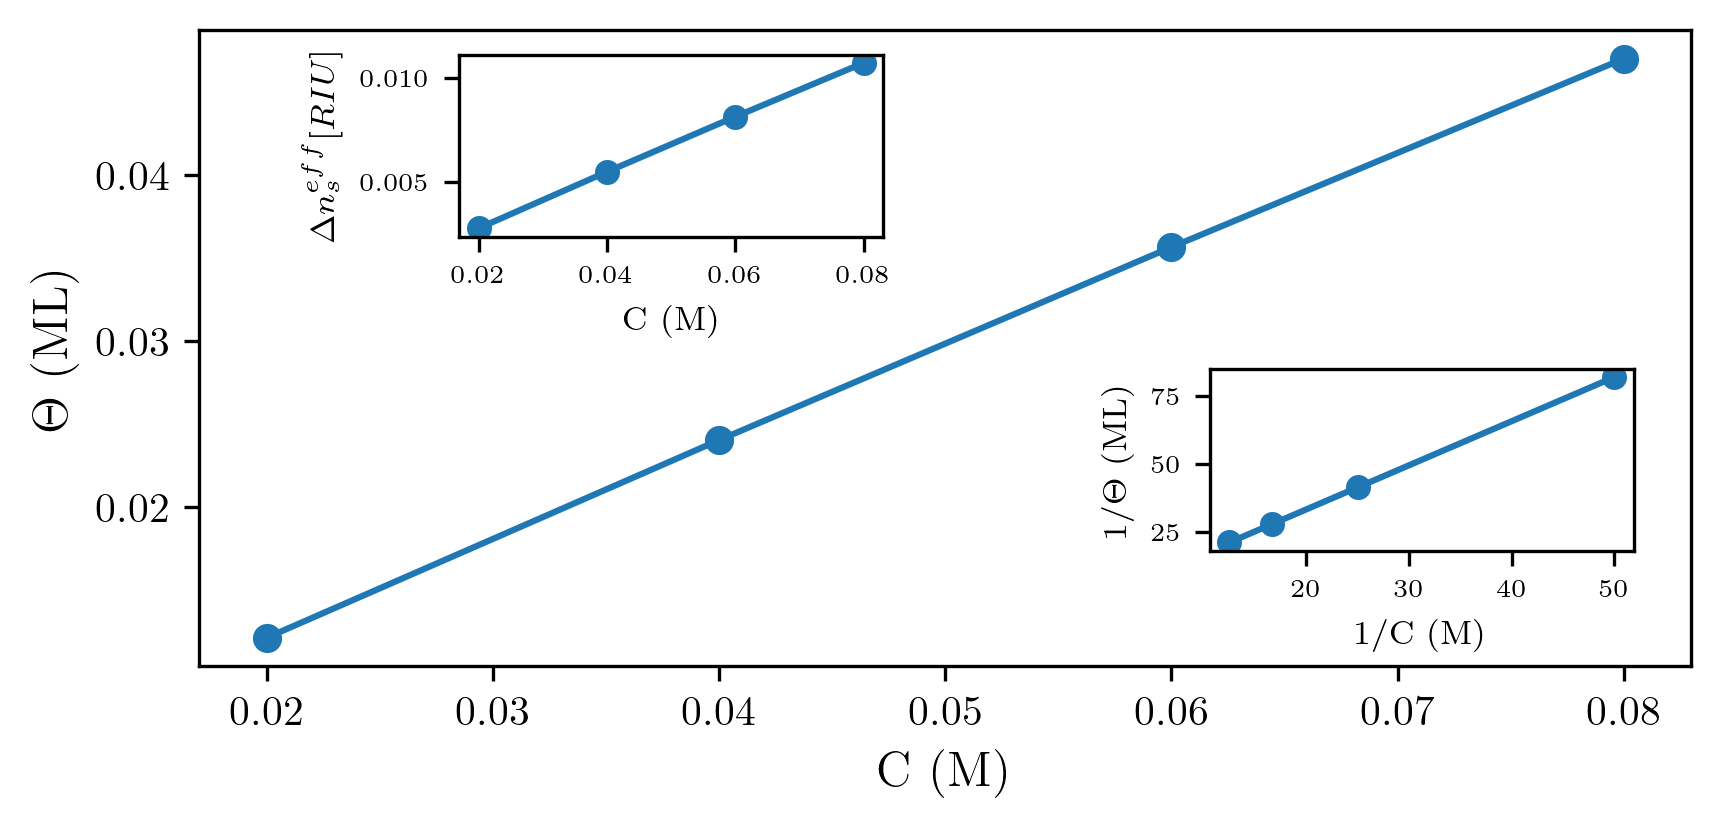

In [12]:
# Plotting the data
C = C_values
Theta = Ka * C / (1 + Ka * C) * Theta_inft_opt
fig, ax = plt.subplots(figsize=(6.417, 2.7559), dpi=300)
ax.scatter(C, Theta, label=r"Estimated points")
ax.plot(C, Theta, label="Linear Interpolation")
ax.set_xlabel("C (M)")
ax.set_ylabel(r"$\Theta$ (ML)")
ax.grid(visible=False)
# ax.legend()
inner_ax = fig.add_axes([0.65, 0.25, 0.22, 0.22])  # [left, bottom, width, height]

# Plot the inverse

inner_ax.scatter(1 / C, 1 / Theta, linewidths=0.01)
inner_ax.plot(1 / C, 1 / Theta)
inner_ax.grid(visible=False)
inner_ax.set_xlabel("1/C (M)", fontsize=8)
inner_ax.set_ylabel(r"1/$\Theta$ (ML)", fontsize=8)
# Adjust the tick label sizes
inner_ax.tick_params(axis="x", labelsize=6)
inner_ax.tick_params(axis="y", labelsize=6)
# inner_ax.set_yticks([0,1e-3,2e-3,3e-3,4e-3])

inner_ax2 = fig.add_axes([0.26, 0.63, 0.22, 0.22])  # [left, bottom, width, height]

# Plot the inverse

inner_ax2.scatter(C, Theta * N_mol_max_opt, linewidths=0.01)
inner_ax2.plot(C, Theta * N_mol_max_opt)
# inner_ax2.set_yticks([0,1e-3,2e-3,3e-3,4e-3])
inner_ax2.grid(visible=False)
inner_ax2.set_xlabel(r"C (M)", fontsize=8)
inner_ax2.set_ylabel(r"$\Delta n_s^{eff} [RIU]$", fontsize=8)
# Adjust the tick label sizes
inner_ax2.tick_params(axis="x", labelsize=6)
inner_ax2.tick_params(axis="y", labelsize=6)

###### A. Finding ka and kd

In [13]:
def fit_thermodynamic_parameters(Theta_exp, C_exp, initial_guess):
    def model(params):
        ka, kd = params
        Theta = (ka * C_exp / (kd + ka * C_exp)) * Theta_inft_opt
        return Theta

    def objective_function(params):
        Theta_model = model(params)
        MSE = np.mean((Theta_model - Theta_exp) ** 2)
        return MSE

    # Define the constraint ka / kd = 15.635998
    def constraint(params):
        ka, kd = params
        return ka / kd - Ka

    # Initial guess for ka and kd
    ka_initial, kd_initial = initial_guess

    # Constraints dictionary for scipy.optimize.minimize
    constraints = {"type": "eq", "fun": constraint}

    # Perform the optimization
    result = minimize(
        objective_function,
        [ka_initial, kd_initial],
        method="SLSQP",
        constraints=constraints,
    )

    # Extract the optimized parameters
    ka_opt, kd_opt = result.x
    mse = result.fun

    return ka_opt, kd_opt, mse

In [14]:
# Initial guesses for ka and kd
C = C_values
initial_guess = [1, 1]
ka_opt, kd_opt, mse = fit_thermodynamic_parameters(Theta, C, initial_guess)

In [15]:
fitvalues = {
    "MSE": [mse],
    "ka": [ka_opt],
    "kd": [kd_opt],
}
pd.DataFrame(fitvalues)

,MSE,ka,kd
0,3.131670e-27,0.755649,1.228706


In [16]:
# Defining Langmuir isotherm function


def Langmuir_Isotherm(Theta, t, theta_inf, C, const):
    ka, kd = const
    dTheta = ka * C * (theta_inf - Theta) - kd * Theta
    return dTheta

In [17]:
Theta_values_LANG_sep = []
Delta_values_LANG_sep = []
# Iterate through C_values and t1_values accordingly
Theta_0 = 0
for i in range(len(C_values)):
    sub_range = time_array[i]
    Theta = sp.integrate.odeint(
        Langmuir_Isotherm,
        Theta_0,
        sub_range,
        args=(Theta_inft_opt, C_values[i], [ka_opt, kd_opt]),
    )
    Theta_values_LANG_sep.append(Theta)

    Delta = N_mol_max_opt * Theta
    Delta_values_LANG_sep.append(Delta)

<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
C:\Users\rodri\AppData\Local\Temp\ipykernel_11424\461946959.py:29: SyntaxWarning: invalid escape sequence '\T'
  + "$\Theta_{\infty}$"


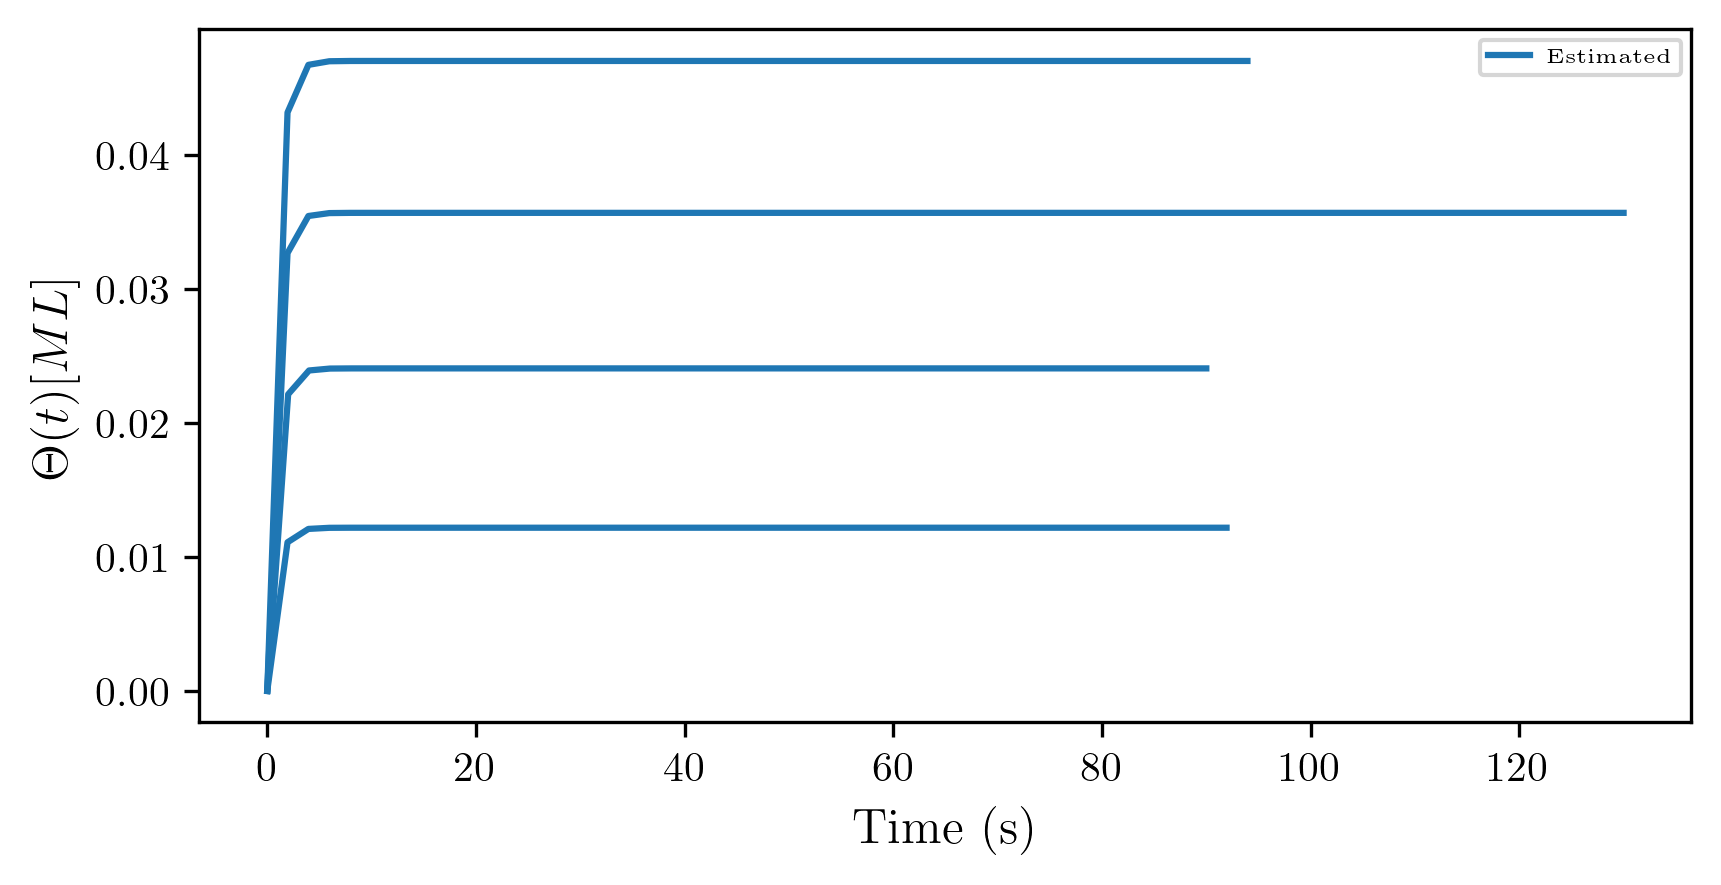

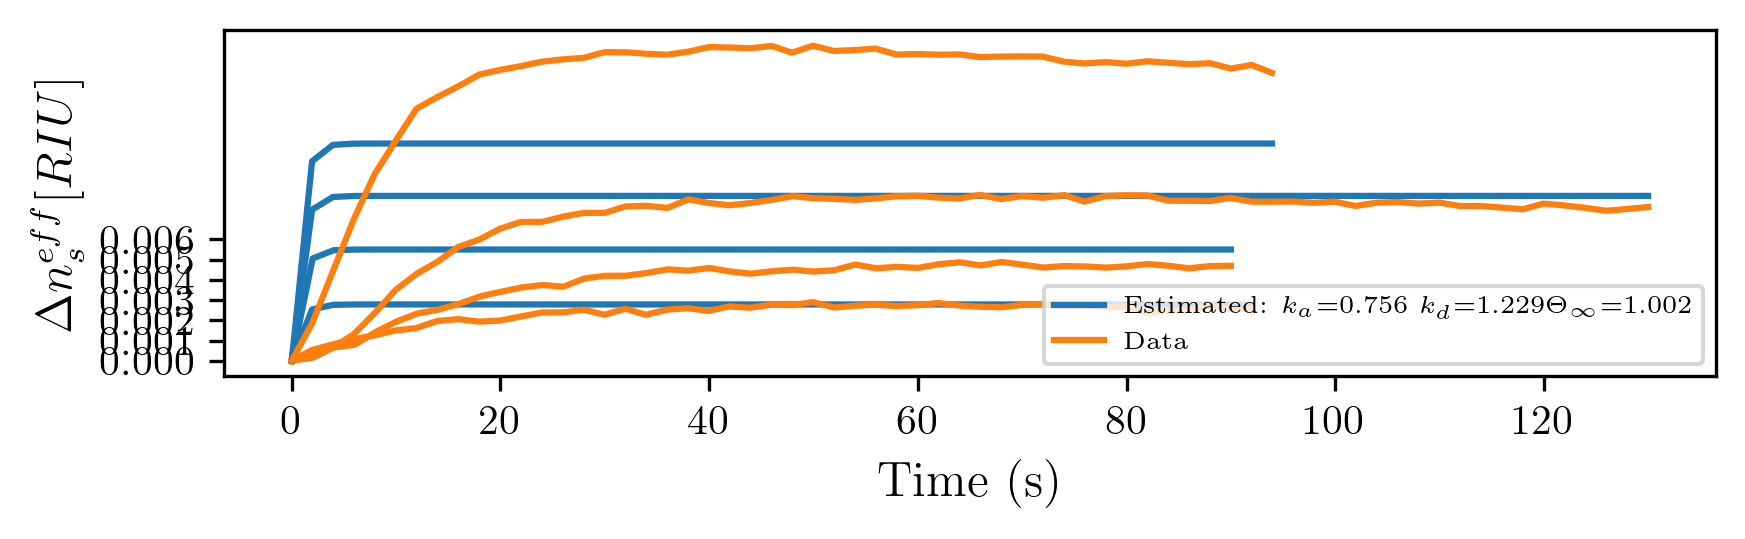

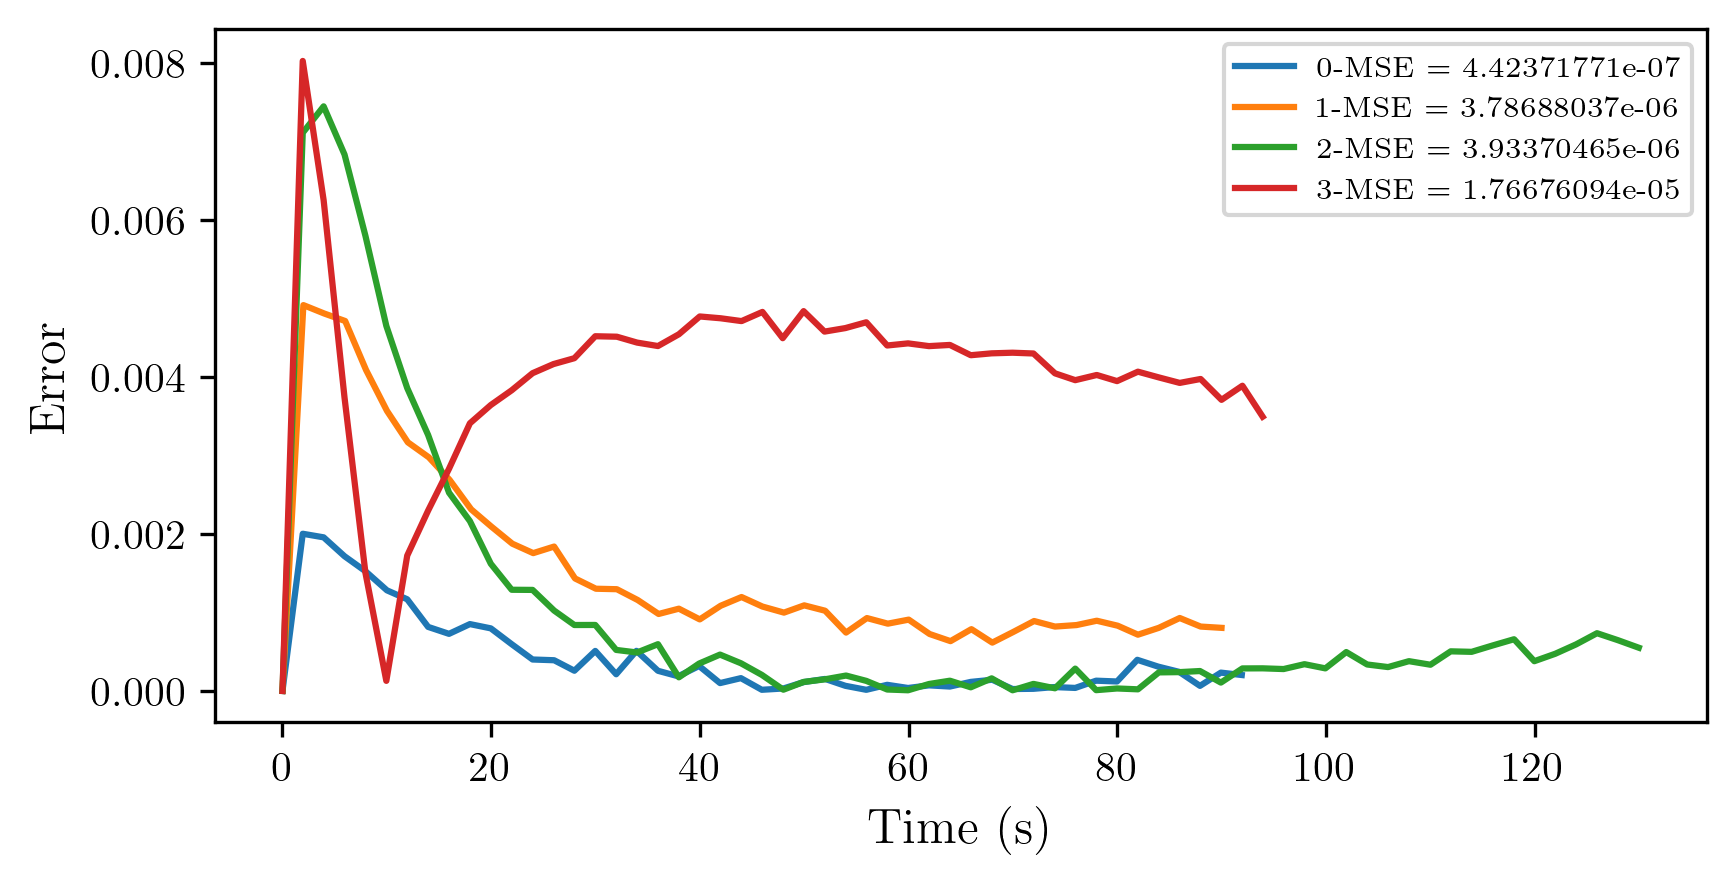

In [18]:
fig1, (ax1) = plt.subplots(figsize=(6.417, 3), dpi=300)
fig2, ax2 = plt.subplots(figsize=(6.417, 1.5), dpi=300)
fig3, ax3 = plt.subplots(figsize=(6.417, 3), dpi=300)

ax1.set_ylabel(r"$\Theta(t) [ML]$")
ax1.set_xlabel(r"Time (s)")
ax2.set_ylabel(r"$\Delta n_s^{eff} [RIU]$")
ax2.set_yticks([0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3])
ax2.set_xlabel(r"Time (s)")
ax3.set_ylabel(r"Error")
ax3.set_xlabel(r"Time (s)")
RMSE = []
for i in range(len(C_values)):
    ax1.plot(
        time_array[i],
        Theta_values_LANG_sep[i],
        color=scientific_colors[0],
        label="Estimated",
    )
    ax2.plot(
        time_array[i],
        Delta_values_LANG_sep[i],
        color=scientific_colors[0],
        label="Estimated:"
        + " $k_a$"
        + f"={ka_opt:.3f}"
        + " $k_d$"
        + f"={kd_opt:.3f}"
        + "$\Theta_{\infty}$"
        + f"={Theta_inft_opt:.3f}",
    )
    ax2.plot(
        time_array[i], refrac_index_array[i], color=scientific_colors[1], label="Data"
    )
    refrac_index_arrayy = np.array(refrac_index_array[i])[:, None]
    RMSE.append(jnp.mean(jnp.square(refrac_index_arrayy - Delta_values_LANG_sep[i])))
    ax3.plot(
        time_array[i],
        np.abs(refrac_index_arrayy - Delta_values_LANG_sep[i]),
        color=scientific_colors[i],
        label=f"{i}-MSE = {RMSE[i]:.8e}",
    )
    ax3.legend(fontsize=7, loc="upper right")

    if i == 0:
        ax2.legend(fontsize=6, loc="lower right")
        ax1.legend(fontsize=5, loc="upper right")

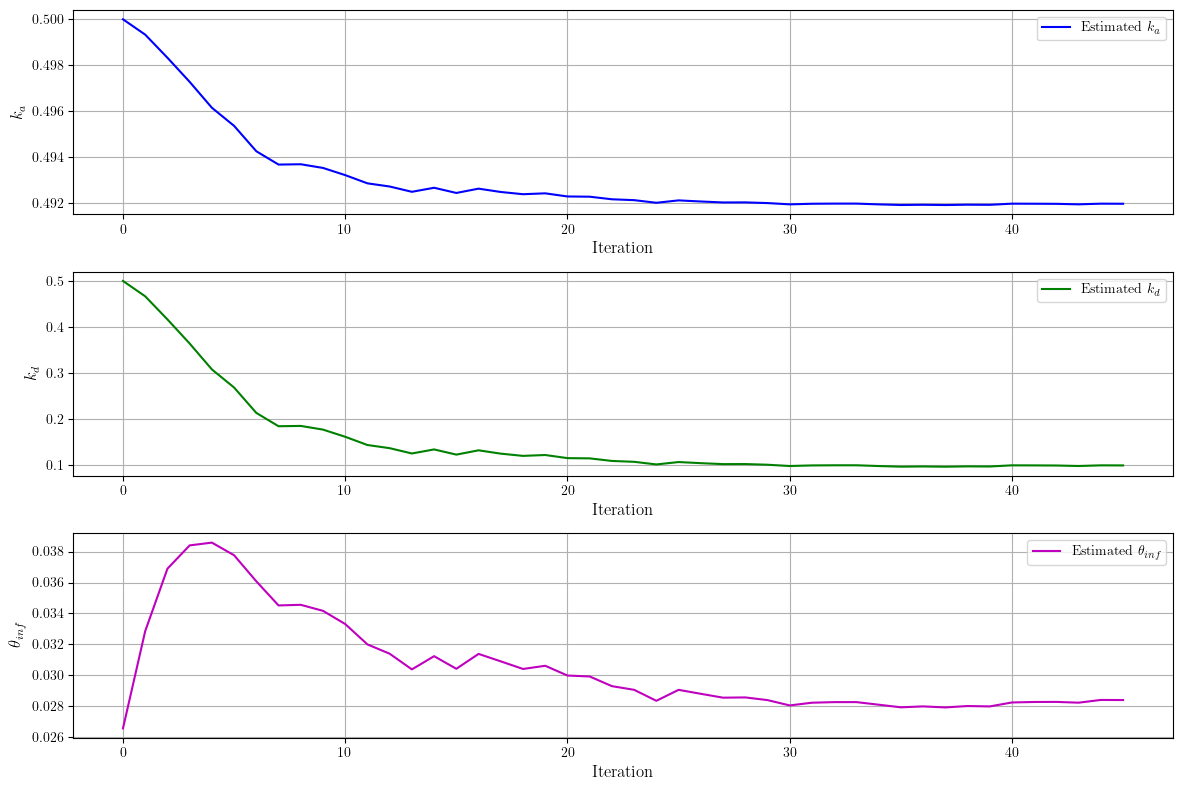

In [19]:
# Define constants for data generation (ground truth)
dt = 2
# Generate synthetic data for multiple experiments
# n_points = len(r_values_train[0])  # Points per experiment
n_experiments = len(C_values)  # Number of experiments
Concentration_anti = jnp.array(C_values)

# Generate step-like inputs for each experiment
u_list = []
for i in range(n_experiments):
    u = C_values[i] * np.ones(len(refrac_index_array[i]))
    u_list.append(u)
    # dt_list.append(np.diff(new_t_values[i]))

# Generate outputs for each expeeriment
y_list = refrac_index_array

# Recursive Least Squares (RLS) for shared parameters
theta = [0, 0, -1]  # [alpha, beta, gamma]
P = np.eye(3) * 1e6  # Covariance matrix
lambda_ = 1  # Forget factor
theta_history = []

# Perform RLS across all experiments
for exp_idx in range(n_experiments - 3):
    u = u_list[exp_idx]
    y = y_list[exp_idx]
    n_points = len(y)
    for k in range(n_points - 1):
        # Regression vector
        phi = np.array([y[k], u[k], u[k] * y[k]])

        # Observed output
        y_obs = y[k + 1]

        # Kalman gain
        K = P @ phi / (lambda_ + phi.T @ P @ phi)

        # Update parameters
        theta += K * (y_obs - phi.T @ theta)

        # Enforce constraints
        theta[0] = min(theta[0], 1 - 1e-6)  # Ensure alpha < 1
        theta[1] = max(theta[1], 1e-6)  # Ensure beta > 0
        theta[2] = min(theta[2], -1e-6)  # Ensure gamma < 0

        theta_history.append(theta.copy())

        # Update covariance matrix
        P = (P - np.outer(K, phi.T @ P)) / lambda_

# Convert theta history to numpy array
theta_history = np.array(theta_history)

# Recover system parameters from theta
alpha_history = theta_history[:, 0]
beta_history = theta_history[:, 1]
gamma_history = theta_history[:, 2]

kd_history = (1 - alpha_history) / dt
ka_history = -gamma_history / dt
theta_inf_history = beta_history / (ka_history * dt)

# Plot the parameter convergence
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ka_history, label="Estimated $k_a$", color="b")
plt.xlabel("Iteration")
plt.ylabel("$k_a$")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(kd_history, label="Estimated $k_d$", color="g")
plt.xlabel("Iteration")
plt.ylabel("$k_d$")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(theta_inf_history, label="Estimated $\\theta_{inf}$", color="m")
plt.xlabel("Iteration")
plt.ylabel("$\\theta_{inf}$")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


0.4919800144701499 0.09900072350750011 0.028390232281324906


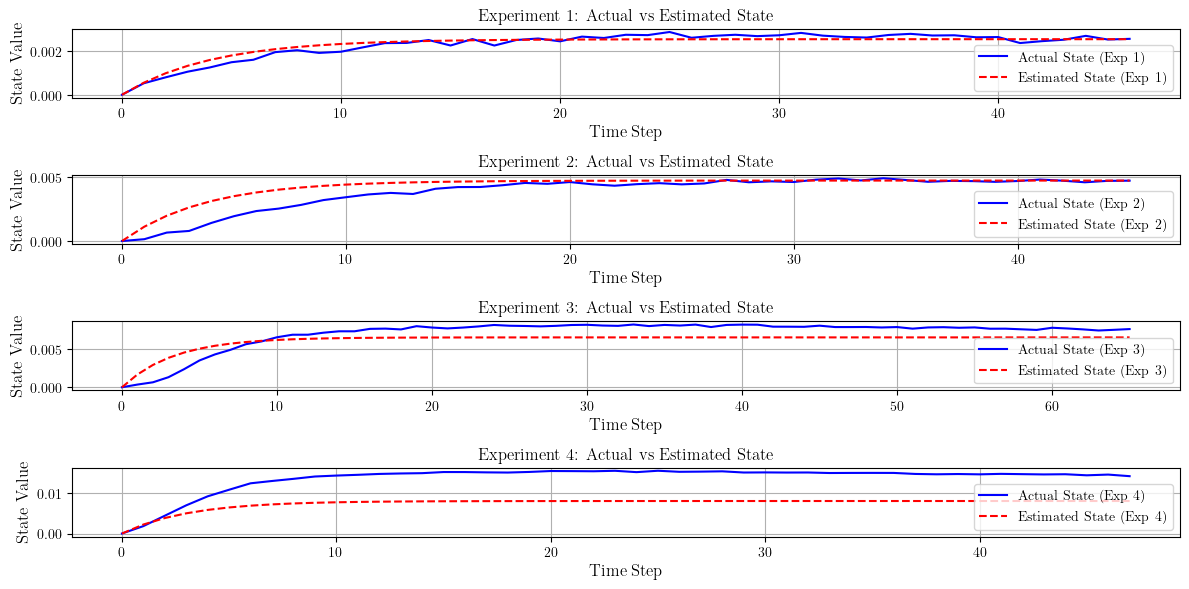

In [20]:
# Redefine constants and variables from previous context for state estimation
final_ka = ka_history[-1]
final_kd = kd_history[-1]
final_theta_inf = theta_inf_history[-1]
print(final_ka, final_kd, final_theta_inf)
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(n_experiments):
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition

    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt * (
            final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1])
            - final_kd * y_hat[k - 1]
        )

    y_hat_list.append(y_hat)

# Plot the actual vs estimated states for all experiments
plt.figure(figsize=(12, 6))

for exp_idx in range(n_experiments):
    n_points = len(y_list[exp_idx])
    plt.subplot(n_experiments, 1, exp_idx + 1)
    plt.plot(
        range(n_points),
        y_list[exp_idx],
        label=f"Actual State (Exp {exp_idx + 1})",
        color="b",
    )
    plt.plot(
        range(n_points),
        y_hat_list[exp_idx],
        label=f"Estimated State (Exp {exp_idx + 1})",
        color="r",
        linestyle="--",
    )
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.title(f"Experiment {exp_idx + 1}: Actual vs Estimated State")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


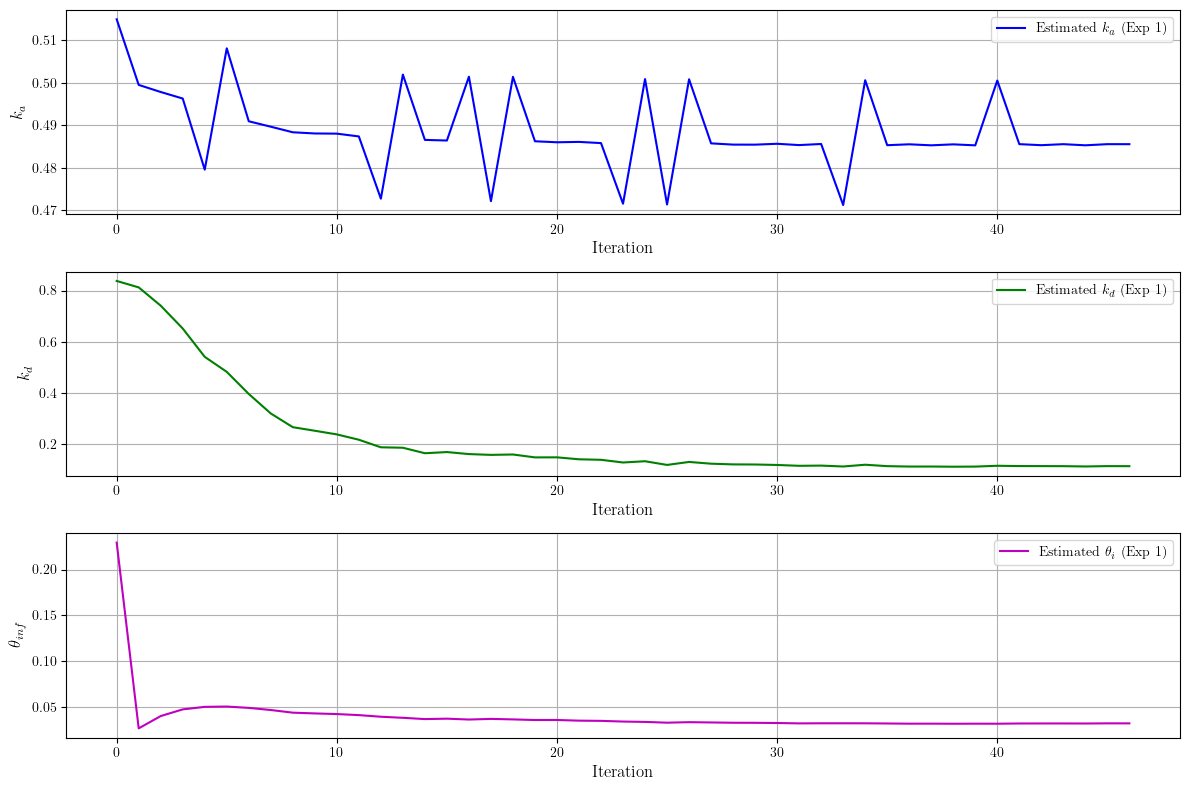

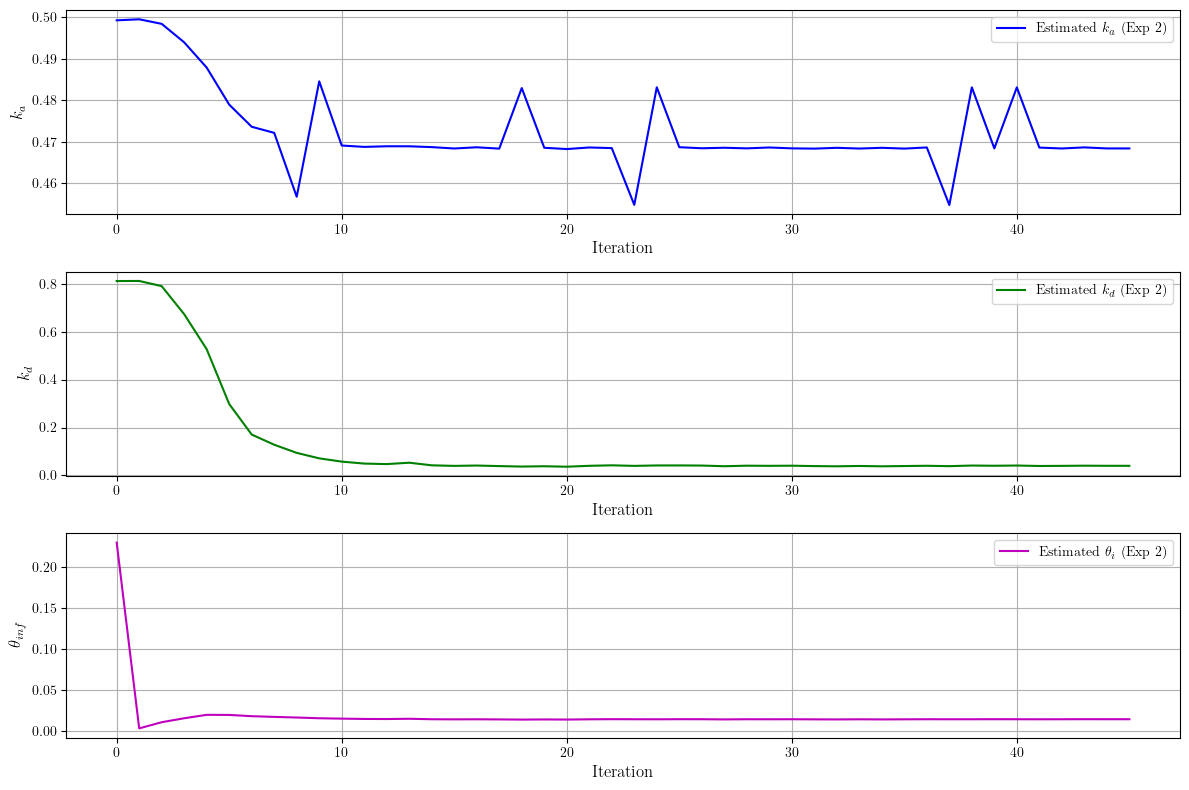

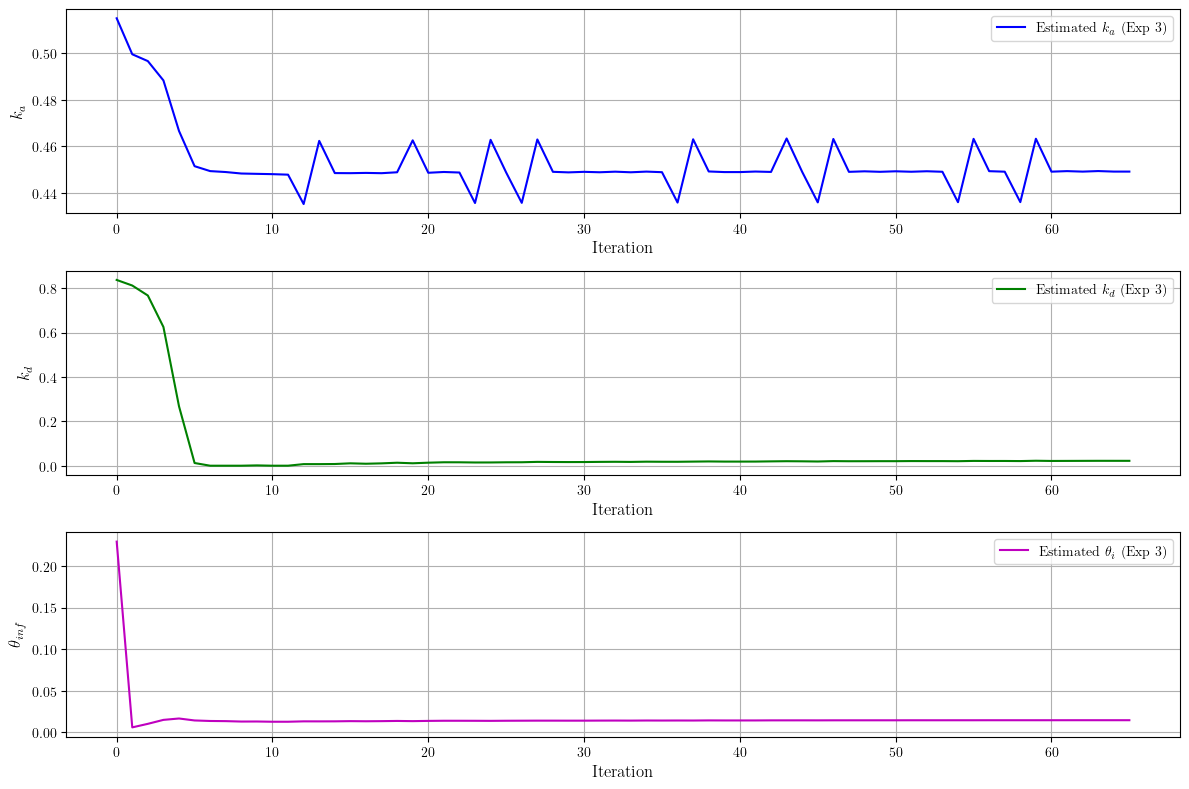

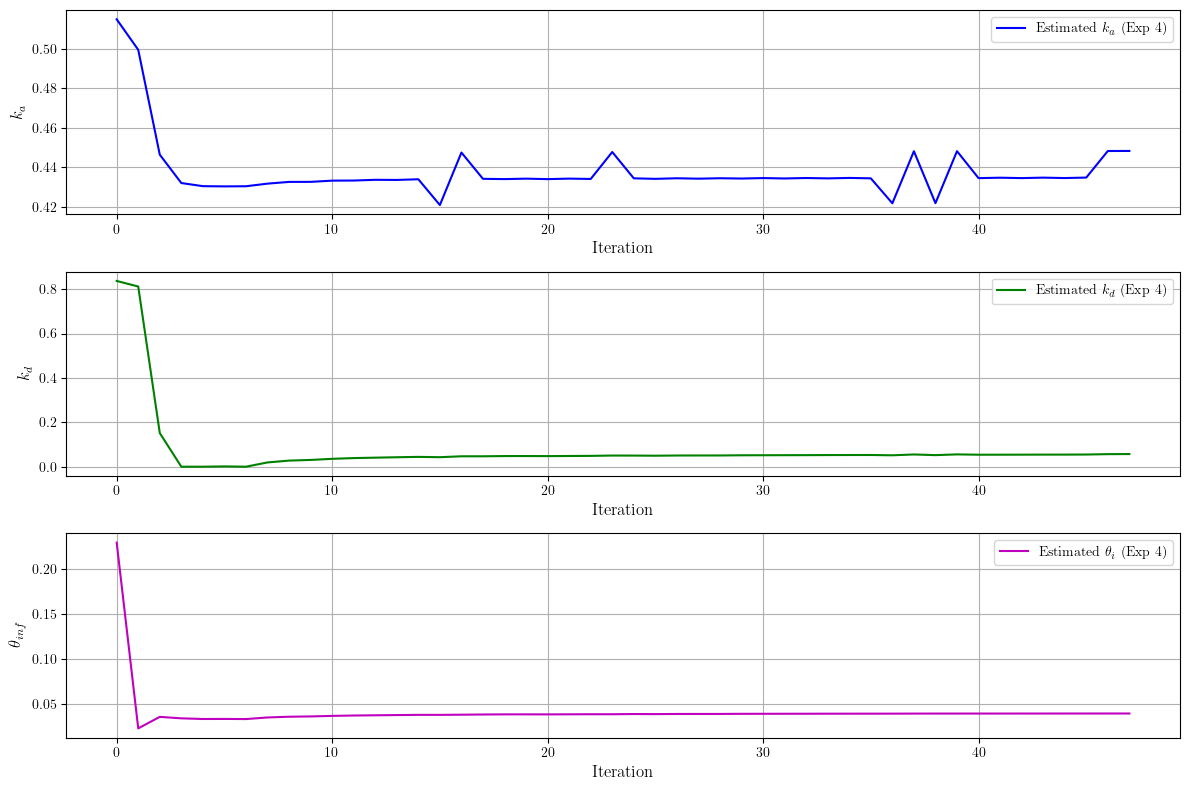

In [21]:
# Define constants for data generation (ground truth)
dt = 2

# Generate synthetic data for multiple experiments
n_experiments = len(C_values)  # Number of experiments
Concentration_anti = jnp.array(C_values)

# Generate step-like inputs for each experiment
u_list = []
dt_list = []
for i in range(n_experiments):
    u = C_values[i] * np.ones(len(refrac_index_array[i]))
    u_list.append(u)
    dt = np.append(np.diff(time_array[i]), np.diff(time_array[i])[-1])
    dt_list.append(dt)

# Generate outputs for each experiment
y_list = refrac_index_array

# Recursive Least Squares (RLS) for experiment-dependent parameters
theta_experiments = []  # To store final thetas for each experiment
theta_history_per_exp = []  # To store theta history for each experiment
P = np.eye(3) * 1e6  # Covariance matrix (same for all experiments)
lambda_ = 1  # Forget factor

gamma = -1
beta = -gamma * var_n_mol_thetainf
alpha = 1 - 1 / Ka

# Initial shared parameters and covariance matrix
theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

# Perform RLS for each experiment sequentially
for exp_idx in range(n_experiments):
    u = u_list[exp_idx]
    y = y_list[exp_idx]
    n_points = len(y)

    # Track theta history for this experiment
    theta_history = []
    theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

    for k in range(n_points - 1):
        # Regression vector
        phi = np.array([y[k], u[k], u[k] * y[k]])

        # Observed output
        y_obs = y[k + 1]

        # Kalman gain
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        # Store theta history for this experiment
        theta_history.append(theta.copy())
        # Update parameters
        theta += K * (y_obs - phi.T @ theta)

        # Enforce constraints
        theta[0] = min(theta[0], 1 - 1e-6)  # Ensure alpha < 1
        theta[1] = max(theta[1], 1e-6)  # Ensure beta > 0
        theta[2] = min(theta[2], -1e-6)  # Ensure gamma < 0

        # Update covariance matrix
        P = (P - np.outer(K, phi.T @ P)) / lambda_

    # Save the final theta for this experiment
    theta_history.append(theta)
    theta_experiments.append(theta.copy())
    theta_history_per_exp.append(np.array(theta_history))

    # Reset covariance matrix for the next experiment
    P = np.eye(3) * 1e6

kd_final_list = []
ka_final_list = []
theta_inf_final_list = []
# Analyze results for each experiment
for exp_idx in range(n_experiments):
    theta_history = theta_history_per_exp[exp_idx]
    dt = dt_list[exp_idx]
    # Recover system parameters from theta
    alpha_history = theta_history[:, 0]
    beta_history = theta_history[:, 1]
    gamma_history = theta_history[:, 2]

    kd_history = (1 - alpha_history) / dt
    ka_history = -gamma_history / dt
    theta_inf_history = beta_history / (ka_history * dt)
    kd_final_list.append(kd_history[-1])
    ka_final_list.append(ka_history[-1])
    theta_inf_final_list.append(theta_inf_history[-1])

    # Plot the parameter convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(ka_history, label=f"Estimated $k_a$ (Exp {exp_idx+1})", color="b")
    plt.xlabel("Iteration")
    plt.ylabel("$k_a$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(kd_history, label=f"Estimated $k_d$ (Exp {exp_idx+1})", color="g")
    plt.xlabel("Iteration")
    plt.ylabel("$k_d$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(
        theta_inf_history, label=f"Estimated $\\theta_i$ (Exp {exp_idx+1})", color="m"
    )
    plt.xlabel("Iteration")
    plt.ylabel("$\\theta_{inf}$")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Nmax 0.999998176260302
ka 0.48555833879969934 kd 0.11513805338424446 thetainf 0.03258153570256174 KA 4.217183846067553
Nmax 0.996503813283291
ka 0.46675465481668743 kd 0.04018350289437735 thetainf 0.014817493332233403 KA 11.615579060978224
Nmax 0.9987666443267642
ka 0.4486248466650725 kd 0.02196243336701446 thetainf 0.01458643592450136 KA 20.42691896513004
Nmax 0.9999361161769093
ka 0.44831744981328325 kd 0.05706860118350957 thetainf 0.039532508342982636 KA 7.855763774052836


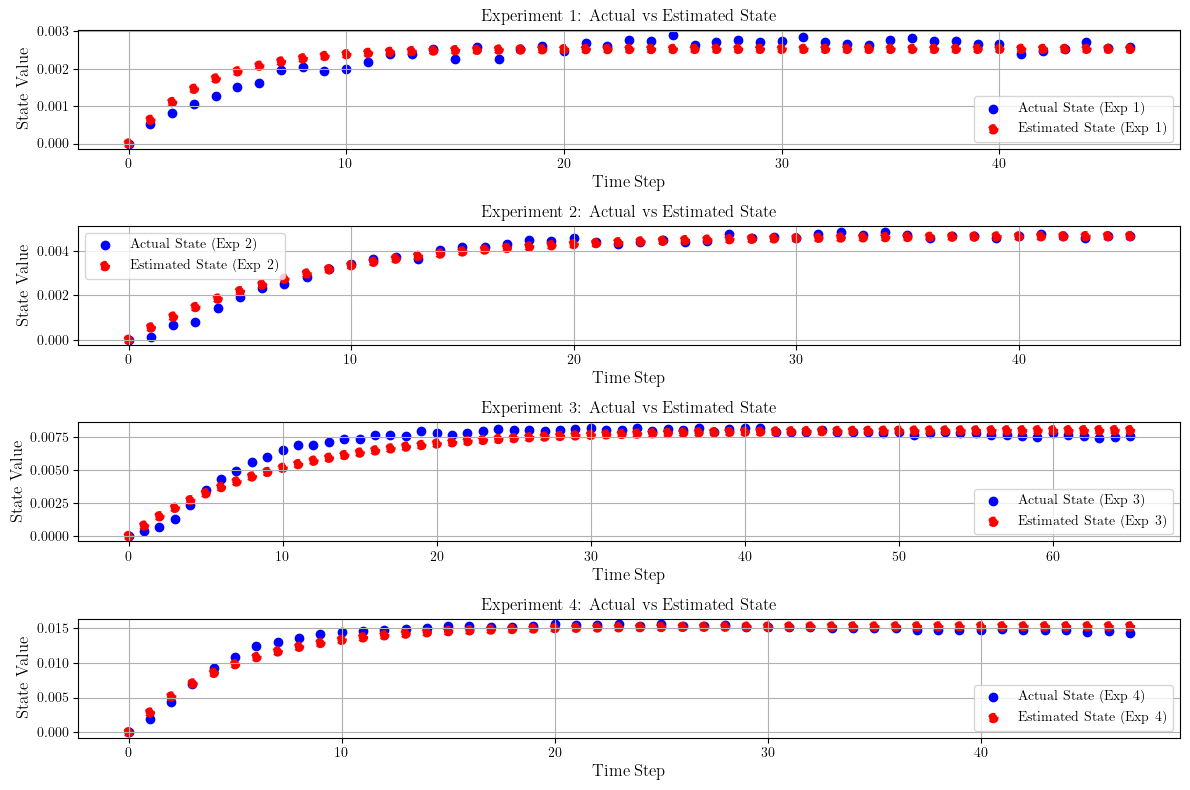

In [22]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(n_experiments):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition

    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (
            final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1])
            - final_kd * y_hat[k - 1]
        )

    y_hat_list.append(y_hat)
    N_max = (y_hat[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    print("Nmax", N_max)
    print(
        "ka",
        final_ka * N_max,
        "kd",
        final_kd * N_max,
        "thetainf",
        final_theta_inf,
        "KA",
        final_ka / final_kd,
    )


# Plot the actual vs estimated states for all experiments
plt.figure(figsize=(12, 8))

for exp_idx in range(n_experiments):
    n_points = len(y_list[exp_idx])
    plt.subplot(n_experiments, 1, exp_idx + 1)
    plt.scatter(
        range(n_points),
        y_list[exp_idx],
        label=f"Actual State (Exp {exp_idx + 1})",
        color="b",
        linewidth=1,
    )
    plt.scatter(
        range(n_points),
        y_hat_list[exp_idx],
        label=f"Estimated State (Exp {exp_idx + 1})",
        color="r",
        linestyle="--",
        linewidth=1.5,
    )
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.title(f"Experiment {exp_idx + 1}: Actual vs Estimated State")
    plt.legend(loc="best")
    plt.grid(True)

plt.tight_layout()
plt.show()

ka 0.4947817109707564 kd 0.11732514612378858 thetainf 0.03197423197451148 KA 4.217183846067553 Nmax 1.018993536061613 LS 1.2268830008321656e-06
ka 0.46831042573894166 kd 0.040317441195178966 thetainf 0.014820082010950095 KA 11.615579060978224 Nmax 0.9998253262893702 LS 9.182343158274675e-07
ka 0.42540472259945666 kd 0.02082569198642476 thetainf 0.015401611871500907 KA 20.42691896513004 Nmax 0.947072036758182 LS 1.279670502751633e-05
ka 0.4186821797741266 kd 0.05329617740760119 thetainf 0.04233341296537093 KA 7.855763774052836 Nmax 0.933837023141048 LS 1.062004446458817e-05


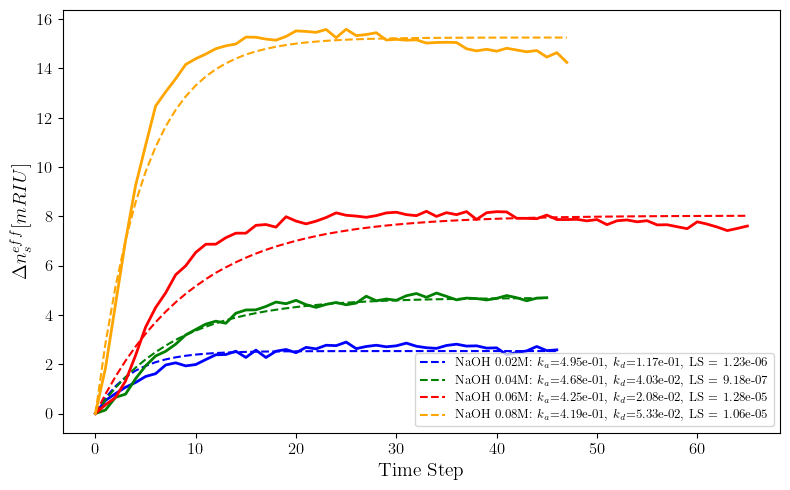

In [23]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(n_experiments):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition

    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (
            final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1])
            - final_kd * y_hat[k - 1]
        )

    y_hat_list.append(y_hat)
    N_max = (y_hat[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    # print(
    #     "ka",
    #     final_ka * N_max,
    #     "kd",
    #     final_kd * N_max,
    #     "thetainf",
    #     final_theta_inf,
    #     "KA",
    #     final_ka / final_kd,
    #     "Nmax",
    #     N_max,
    # )
# plt.rc('font', family='Times New Roman', size=14)  # Use Times New Roman font
plt.rc("axes", titlesize=14)  # Title font size
plt.rc("axes", labelsize=14)  # Label font size
plt.rc("xtick", labelsize=12)  # X-tick font size
plt.rc("ytick", labelsize=12)  # Y-tick font size
plt.rc("legend", fontsize=12)  # Legend font size
# plt.rc('font', family='serif', size=12)  # Use the default serif font
# Define a list of colors for each experiment
colors = [
    "blue",
    "green",
    "red",
    "orange",
    "purple",
    "brown",
    "pink",
    "cyan",
]  # Extend if needed

# Create the plot
plt.figure(figsize=(8, 5))  # Square figure size

for exp_idx in range(n_experiments):
    color = colors[exp_idx % len(colors)]  # Cycle colors if needed
    n_points = len(y_list[exp_idx])
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    y_hat = y_hat_list[exp_idx]
    N_max = (np.array(y)[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    # Format constants for the legend
    MSE_value = (1/2)*np.sum((y_hat-y)**2)
    print(
        "ka",
        final_ka * N_max,
        "kd",
        final_kd * N_max,
        "thetainf",
        final_theta_inf/N_max,
        "KA",
        final_ka / final_kd,
        "Nmax",
        N_max,
        "LS",
        MSE_value
    )
    legend_label = (
        f"NaOH 0.0{2*(exp_idx+1)}M:"
        f" $k_a$={final_ka * N_max:.2e}, "
        f" $k_d$={final_kd * N_max:.2e},"
        f" LS = {MSE_value:.2e}"
    )
    # Plot actual state
    plt.plot(
        range(n_points),
        y_list[exp_idx] * 1e3,
        # label=f"Actual State (Exp {exp_idx + 1})",
        color=color,
        linewidth=2,
    )

    # Plot estimated state
    plt.plot(
        range(n_points),
        y_hat_list[exp_idx] * 1e3,
        label=legend_label,
        color=color,
        linestyle="--",
        linewidth=1.5,
    )

# Configure axis labels, legend, and grid
plt.xlabel("Time Step")
plt.ylabel(r"$\Delta n_s^{eff} [mRIU]$")
plt.legend(loc="best", fontsize=9)
plt.grid(False)

# Ensure square plot
plt.gca().set_aspect("auto", adjustable="box")

# Display the plot
plt.tight_layout()
plt.savefig("estimated_state_NaOH.png", dpi=300)
plt.show()